Imports:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import os
import pydot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.models import Sequential, Model

Load images:

In [5]:
folder_path = 'drive/My Drive/foods/'
aim_folder_path = 'foodpreprocessed/'

img_width, img_height = 224, 224

# load all images into a list
file_list = sorted(os.listdir(folder_path))
images = []
names = []
i = 0
for img in file_list:
    if img == '.DS_Store':  # ignore stupid fookin mac file that wont go away
        continue
    thisname = img.split('.')[0]
    names.append(img)
    img = os.path.join(folder_path, img)
    img = image.load_img(img, target_size=(img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    np.save(aim_folder_path+thisname, img)
    images.append(img)
    i = i + 1
    if i % 100 == 0:
      print(i)

# stack up images list to pass for prediction
images = np.vstack(images)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000


Load triplets:

In [2]:
df_triplets = pd.read_csv('train_triplets.txt', sep=" ", header=None)
print(df_triplets)

          0     1     2
0      2461  3450  2678
1      2299  2499  4987
2      4663  1056  3029
3      4532  1186  1297
4      3454  3809  2204
...     ...   ...   ...
59510   466  2952  2530
59511  2646  3580  2359
59512  3255  4844  4334
59513  2136  4619   161
59514  2509  2552  3406

[59515 rows x 3 columns]


Train-validation split:

In [3]:
df_triplets_train = pd.DataFrame(columns = [0, 1, 2])
df_triplets_val = pd.DataFrame(columns = [0, 1, 2])

N = 325
for idx, row in df_triplets.iterrows():
  if idx < N:  # first N rows go in train
    df_triplets_train = df_triplets_train.append(row)
  elif all(x not in df_triplets_train.values for x in [row[0], row[1], row[2]]):  # else if images not in train add to val
    df_triplets_val = df_triplets_val.append(row)
  elif all(x not in df_triplets_val.values for x in [row[0], row[1], row[2]]):  # else if images not in val add to train
    df_triplets_train = df_triplets_train.append(row)
  # else we discard triplet
  
df_triplets_train = df_triplets_train.reset_index(drop=True)
df_triplets_val = df_triplets_val.reset_index(drop=True)

print(df_triplets_train)
print(df_triplets_val)

          0     1     2
0      2461  3450  2678
1      2299  2499  4987
2      4663  1056  3029
3      4532  1186  1297
4      3454  3809  2204
...     ...   ...   ...
15887   450   219  4712
15888   236  1229  4090
15889   880  1818   621
15890   466  2952  2530
15891  2646  3580  2359

[15892 rows x 3 columns]
         0     1     2
0      647  4571  3011
1      683  2848  2039
2     4404  2384  2478
3     1019  4241  4114
4     4108  1020  1523
...    ...   ...   ...
5000  4020  2390  1285
5001  4990  4028  2647
5002  1716  4431  3398
5003  1550  1222  1140
5004  1940    38  2869

[5005 rows x 3 columns]


Swap every other element so that 0/1 labels are balanced:

In [4]:
for i, row in df_triplets_train.iterrows():
  if i % 2 == 1:
    temp = row[1]
    df_triplets_train.at[i,1] = row[2]
    df_triplets_train.at[i,2] = temp
print(df_triplets_train)

for i, row in df_triplets_val.iterrows():
  if i % 2 == 1:
    temp = row[1]
    df_triplets_val.at[i,1] = row[2]
    df_triplets_val.at[i,2] = temp
print(df_triplets_val)

          0     1     2
0      2461  3450  2678
1      2299  4987  2499
2      4663  1056  3029
3      4532  1297  1186
4      3454  3809  2204
...     ...   ...   ...
15887   450  4712   219
15888   236  1229  4090
15889   880   621  1818
15890   466  2952  2530
15891  2646  2359  3580

[15892 rows x 3 columns]
         0     1     2
0      647  4571  3011
1      683  2039  2848
2     4404  2384  2478
3     1019  4114  4241
4     4108  1020  1523
...    ...   ...   ...
5000  4020  2390  1285
5001  4990  2647  4028
5002  1716  4431  3398
5003  1550  1140  1222
5004  1940    38  2869

[5005 rows x 3 columns]


Create labels:

In [5]:
y_train = np.empty((df_triplets_train.shape[0], 1))
y_train[::2] = 1
y_train[1::2] = 0
print(y_train)

y_val = np.empty((df_triplets_val.shape[0], 1))
y_val[::2] = 1
y_val[1::2] = 0
print(y_val)

[[1.]
 [0.]
 [1.]
 ...
 [0.]
 [1.]
 [0.]]
[[1.]
 [0.]
 [1.]
 ...
 [1.]
 [0.]
 [1.]]


Transform triplets of image indexes --> triplets of images:

In [0]:
def imageLoader(files, y_values, batch_size):

    im0 = files[0]
    im1 = files[1]
    im2 = files[2]
    
    L = len(im0)

    #this line is just to make the generator infinite, keras needs that    
    while True:
        
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            X = [someMethodToLoadImages(im0[batch_start:limit]),someMethodToLoadImages(im1[batch_start:limit]),someMethodToLoadImages(im2[batch_start:limit])]
            Y = y_values[batch_start:batch_end]
            #print(Y)
            Y = np.vstack(Y)
            #print(X)
            #print(Y.shape)
            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size
            
def someMethodToLoadImages(im0):
    train_0 = []
    aim_folder_path = 'foodpreprocessed/'

    for imID in im0:
        train_0.append(np.load(aim_folder_path+str(imID).zfill(5)+'.npy'))
      #  print(train_0[-1].shape)
    train_0 = np.vstack(train_0)
    
    return train_0

Setup model for transfer learning:

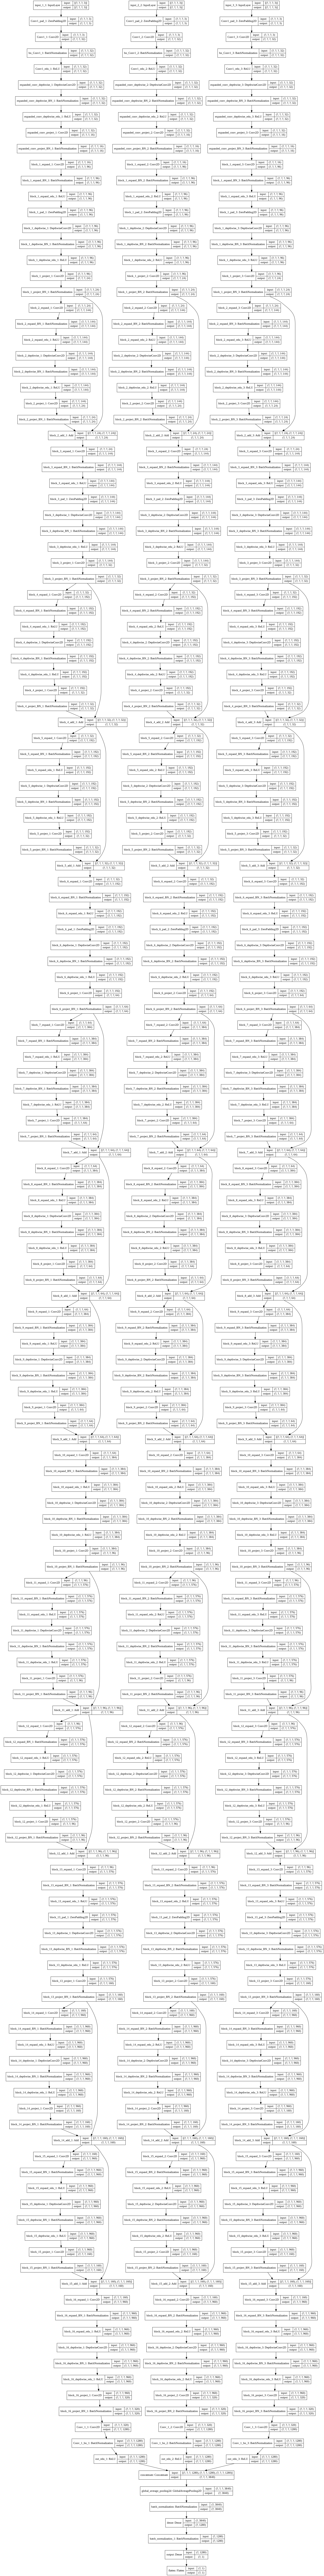

In [10]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.optimizers import SGD
model1 = MobileNetV2(weights='imagenet', include_top=False)
model2 = MobileNetV2(weights='imagenet', include_top=False)
model3 = MobileNetV2(weights='imagenet', include_top=False)

#  Make sure all layer names are unique (otherwise it gets upset) and freeze all pre-trained layers:
for layer in model1.layers:
  layer.trainable = False
  layer._name = layer._name + str("_1")
for layer in model2.layers:
  layer.trainable = False
  layer._name = layer._name + str("_2")
for layer in model3.layers:
  layer.trainable = False
  layer._name = layer._name + str("_3")

out1 = model1.output
out2 = model2.output
out3 = model3.output

x = layers.concatenate([out1, out2, out3])
#out = layers.Dense(1, activation='softmax', name='output', input_dim=2)(x)
#outf = layers.Flatten()(out)
x = layers.GlobalAveragePooling2D()(x)
# x = Dropout(rate = .2)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(1280, activation='relu')(x)
# x = Dropout(rate = .2)(x)
x = layers.BatchNormalization()(x)
out = layers.Dense(1, activation='softmax', name='output')(x)
outf = layers.Flatten()(out)

model = Model(inputs=[model1.input,model2.input,model3.input], outputs=outf)

opt = SGD(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

dot_img_file = 'model_1.png'
plot_model(model, to_file=dot_img_file, show_shapes=True)


Train model:

In [0]:
#for layer in model.layers:
#    print(layer.output_shape)


batch_size = 256
spe = df_triplets_train.shape[0]//batch_size
vs = df_triplets_val.shape[0]//batch_size
my_training_batch_generator = imageLoader(df_triplets_train, y_train, batch_size)
my_validation_batch_generator = imageLoader(df_triplets_val, y_val, batch_size)
model.fit(my_training_batch_generator,validation_data=(my_validation_batch_generator), steps_per_epoch=spe, validation_steps=vs, epochs=5)

Epoch 1/5
47/62 [=====================>........] - ETA: 6:03 - loss: 7.6246 - accuracy: 0.5000

In [0]:
def imageLoader(files, batch_size):

    im0 = files[0]
    im1 = files[1]
    im2 = files[2]
    
    L = len(im0)

    #this line is just to make the generator infinite, keras needs that    
    while True:
        
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            X = [someMethodToLoadImages(im0[batch_start:limit]),someMethodToLoadImages(im1[batch_start:limit]),someMethodToLoadImages(im2[batch_start:limit])]
            #print(Y)
            #print(X)
            #print(Y.shape)
            yield (X) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

df_triplets_test = pd.read_csv('test_triplets.txt', sep=" ", header=None)
print(df_triplets_test)
my_testing_batch_generator = imageLoader(df_triplets_train)
prediction = model.predict)